### machine learning 5-fold comparison

In [18]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [19]:
# prepare (flatten) 5-fold dataset features and labels
feature_list_train_all = []
label_list_train_all = []

for i in range(5):

    trainpath = '../datasets/fivefold/'+str(i+1)+'fold_train_evidence.dataset'
    validpath = '../datasets/fivefold/'+str(i+1)+'fold_valid_evidence.dataset'
    train = pd.read_pickle(trainpath)
    test = pd.read_pickle(validpath)

    # fold-i label
    label_train = train['label'].values
    label_list_train_all.append(label_train)

    # fold-i features
    feature = np.zeros(shape=(train.shape[0],7225))
    for j in range(train.shape[0]):
        feature_list = []
        for item in train['fingerprint'][j]:
            feature_list.append(item) # 881
        for item in np.nditer(train['seqbefore'][j]):
            feature_list.append(item) # 1220
        for item in np.nditer(train['seqafter'][j]):
            feature_list.append(item) # 1220
        for item in train['variantfeature'][j]:
            feature_list.append(item) # 3904
        for k in range(len(feature_list)):
            feature[j, k] = feature_list[k]
    feature_list_train_all.append(feature)

feature_train_all = np.array(feature_list_train_all)
label_train_all = np.array(label_list_train_all)

print(feature_train_all.shape) # (5,480,7225)
print(label_train_all.shape) # (5,480)


(5, 480, 7225)
(5, 480)


In [20]:
# prepare (flatten) testset features and labels
alltestpath = '../datasets/middlefile/test_data_evidence.dataset'
alltest = pd.read_pickle(alltestpath)
label = alltest['label'].values
feature = np.zeros(shape=(alltest.shape[0],7225))
for j in range(alltest.shape[0]):
    feature_list = []
    for item in alltest['fingerprint'][j]:
        feature_list.append(item) # 881
    for item in np.nditer(alltest['seqbefore'][j]):
        feature_list.append(item) # 1220
    for item in np.nditer(alltest['seqafter'][j]):
        feature_list.append(item) # 1220
    for item in alltest['variantfeature'][j]:
        feature_list.append(item) # 3904
    for k in range(len(feature_list)):
        feature[j, k] = feature_list[k]
print(feature.shape) # (153, 7225)
print(label.shape) # (153,)

(153, 7225)
(153,)


In [21]:
label_train_all = label_train_all.astype('int')
label = label.astype('int')

In [22]:
print(feature_train_all[0])

[[1. 1. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 0. 0.]
 ...
 [1. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 0. 0.]]


#### Model 1: Decision tree

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

paramGride = dict(
    max_depth = [1,3,5,10,15,20],
    max_leaf_nodes = [2,3,4,5,10,15,20],)

dtModel = DecisionTreeClassifier()
grid = GridSearchCV(
    dtModel,paramGride,cv = 5,return_train_score = True)
grid = grid.fit(feature_train_all[0],label_train_all[0])

In [21]:
print('best_score：%f'% grid.best_score_)
print('best paramaters:')

for key in grid.best_params_.keys():
    print('%s = %s'%(key,grid.best_params_[key]))

best_score：0.766667
best paramaters:
max_depth = 3
max_leaf_nodes = 3


(mean) ACC:  0.7686274509803921 Precision:  0.8296154026185418 Recall:  0.8612612612612613 F1:  0.8425415025222737 AUC:  0.8181126916997735
(std) ACC:  0.025347345659693245 Precision:  0.02752731560460982 Recall:  0.06992291139435047 F1:  0.02498820667062427 AUC:  0.015081216716204937


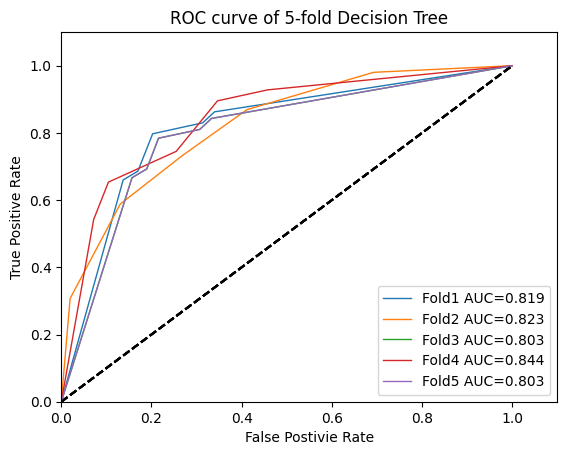

In [28]:
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

dt_prob_list = []

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5):

    clf_dt = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3)
    clf_dt.fit(feature_train_all[i],label_train_all[i])

    y_score = clf_dt.predict(feature)                                   
    y_score_pro = clf_dt.predict_proba(feature) # (.., 2)
    y_one_hot = to_categorical(label)
    y_score_one_hot = to_categorical(y_score)

    dt_prob_list.append(y_score_pro)

    acc_list.append(accuracy_score(label, y_score))
    precision_list.append(precision_score(label, y_score))
    recall_list.append(recall_score(label, y_score))
    f1_list.append(f1_score(label, y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold Decision Tree')
plt.savefig('images/roc-5fold-decision-tree.png',dpi=300)
plt.show()

#### Model 2: Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

paramGride = dict(
    n_estimators = [3,5,10,15],
    max_depth = [11,15,20],
    min_samples_split = [10,20,40,60],)

rfModel = RandomForestClassifier()
grid = GridSearchCV(
    rfModel,paramGride,cv = 5,return_train_score = True)
grid = grid.fit(feature_train_all[0],label_train_all[0])

In [41]:
print('best_score：%f'% grid.best_score_)
print('best paramaters:')

for key in grid.best_params_.keys():
    print('%s = %s'%(key,grid.best_params_[key]))

best_score：0.754167
best paramaters:
max_depth = 11
min_samples_split = 10
n_estimators = 10


(mean) ACC:  0.7908496732026143 Precision:  0.8244464618986076 Recall:  0.9045045045045047 F1:  0.8625619002754166 AUC:  0.8607544106967406
(std) ACC:  0.021873464745988933 Precision:  0.01592125683714042 Recall:  0.01570774394068711 F1:  0.01415728037675404 AUC:  0.014858043143245651


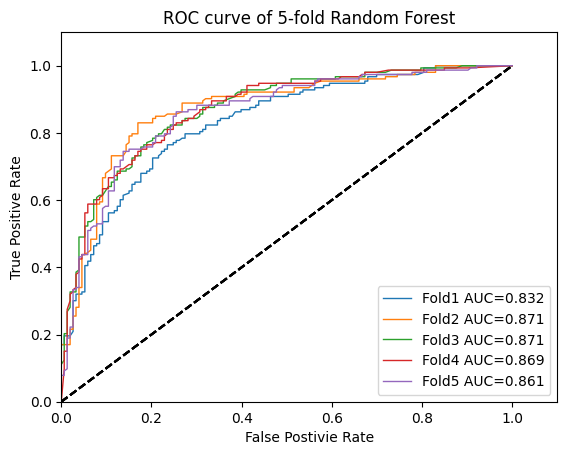

In [30]:
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

rf_prob_list = []

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5):

    clf_rf = RandomForestClassifier(n_estimators=10, max_depth=11, min_samples_split=10)
    clf_rf.fit(feature_train_all[i],label_train_all[i])

    y_score = clf_rf.predict(feature)                                   
    y_score_pro = clf_rf.predict_proba(feature) # (.., 2)
    y_one_hot = to_categorical(label)
    y_score_one_hot = to_categorical(y_score)

    rf_prob_list.append(y_score_pro)

    acc_list.append(accuracy_score(label, y_score))
    precision_list.append(precision_score(label, y_score))
    recall_list.append(recall_score(label, y_score))
    f1_list.append(f1_score(label, y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold Random Forest')
plt.savefig('images/roc-5fold-random-forest.png',dpi=300)
plt.show()

#### Model 3: SVM

In [43]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

paramGride = dict(
    gamma = [1e-4, 1e-3, 0.01, 0.1, 1, 10],
    C = [100, 10, 1, 0.1, 1e-2, 1e-3],)

svmModel = SVC()
grid = GridSearchCV(
    svmModel,paramGride,cv = 5,return_train_score = True)
grid = grid.fit(feature_train_all[0],label_train_all[0])

print('best_score：%f'% grid.best_score_)
print('best paramaters:')

for key in grid.best_params_.keys():
    print('%s = %s'%(key,grid.best_params_[key]))

best_score：0.737500
best paramaters:
C = 10
gamma = 0.0001


(mean) ACC:  0.7477124183006536 Precision:  0.751393778635158 Recall:  0.9747747747747747 F1:  0.8486265342751274 AUC:  0.7841172198726987
(std) ACC:  0.0032019473761871497 Precision:  0.002037989929489616 Recall:  0.0036036036036035664 F1:  0.0019552965589099244 AUC:  0.01674333878185786


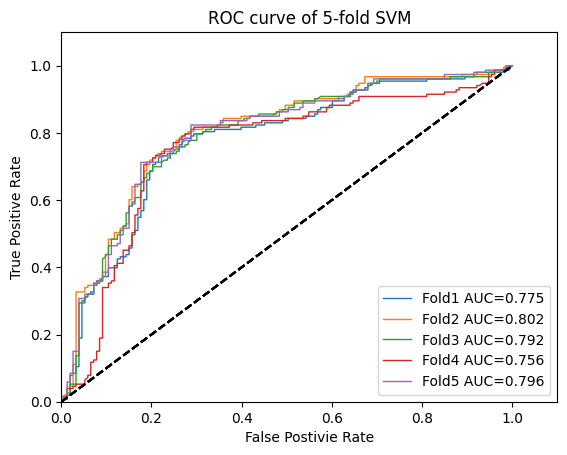

In [31]:
from sklearn.svm import SVC
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

svm_prob_list = []

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5):

    clf_svm = SVC(probability = True)
    clf_svm.fit(feature_train_all[i],label_train_all[i])

    y_score = clf_svm.predict(feature)                                   
    y_score_pro = clf_svm.predict_proba(feature) # (.., 2)
    y_one_hot = to_categorical(label)
    y_score_one_hot = to_categorical(y_score)

    svm_prob_list.append(y_score_pro)

    acc_list.append(accuracy_score(label, y_score))
    precision_list.append(precision_score(label, y_score))
    recall_list.append(recall_score(label, y_score))
    f1_list.append(f1_score(label, y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold SVM')
plt.savefig('images/roc-5fold-svm.png',dpi=300)
plt.show()

#### Model 4: KNN

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

paramGride = dict(
    n_neighbors = [20,30,40,50,60,70,80,100],)

knnModel = KNeighborsClassifier()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True,scoring='roc_auc')
grid = grid.fit(feature_train_all[0],label_train_all[0])

print('best_score：%f'% grid.best_score_)
print('best paramaters:')

for key in grid.best_params_.keys():
    print('%s = %s'%(key,grid.best_params_[key]))

best_score：0.639916
best paramaters:
n_neighbors = 40


(mean) ACC:  0.7111111111111111 Precision:  0.7233096364373564 Recall:  0.9747747747747747 F1:  0.8304057983435053 AUC:  0.7879020889401513
(std) ACC:  0.007622159339667032 Precision:  0.005737247012796363 Recall:  0.0036036036036035664 F1:  0.0038177971181820353 AUC:  0.007416288244935805


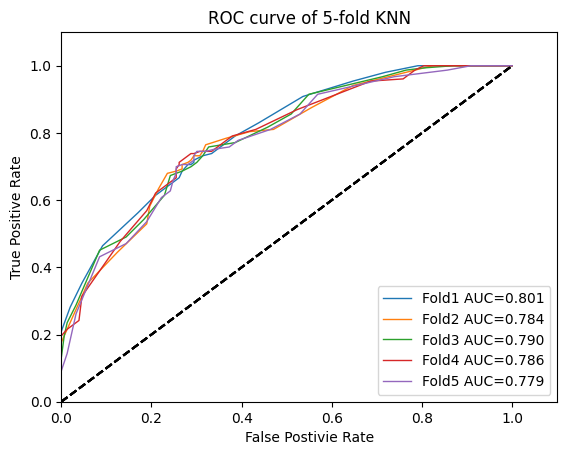

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

knn_prob_list = []

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5):

    clf_knn = KNeighborsClassifier(n_neighbors = 40)
    clf_knn.fit(feature_train_all[i],label_train_all[i])

    y_score = clf_knn.predict(feature)                                   
    y_score_pro = clf_knn.predict_proba(feature) # (.., 2)
    y_one_hot = to_categorical(label)
    y_score_one_hot = to_categorical(y_score)

    knn_prob_list.append(y_score_pro)

    acc_list.append(accuracy_score(label, y_score))
    precision_list.append(precision_score(label, y_score))
    recall_list.append(recall_score(label, y_score))
    f1_list.append(f1_score(label, y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold KNN')
plt.savefig('images/roc-5fold-knn.png',dpi=300)
plt.show()

#### Model 5: XGBoost

In [23]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

other_params = {'eta': 0.3, 'n_estimators': 50, 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1,
                'colsample_bytree': 1, 'colsample_bylevel': 1, 'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0,
                'seed': 33}

cv_params = {'n_estimators': np.linspace(1, 10, 11, dtype=int)} 
# cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 

xgb_model = xgb.XGBClassifier(**other_params)
gs = GridSearchCV(xgb_model, cv_params, verbose=2, refit=True, cv=5, n_jobs=-1)
gs.fit(feature_train_all[0],label_train_all[0])
gs.best_params_

Fitting 5 folds for each of 11 candidates, totalling 55 fits


{'n_estimators': 5}

(mean) ACC:  0.8156862745098039 Precision:  0.8572312891136455 Recall:  0.8954954954954955 F1:  0.8756967385000001 AUC:  0.8906061771113674
(std) ACC:  0.02723224399477078 Precision:  0.020312298229837603 Recall:  0.027087020501572787 F1:  0.018560330969694103 AUC:  0.01427449707700323


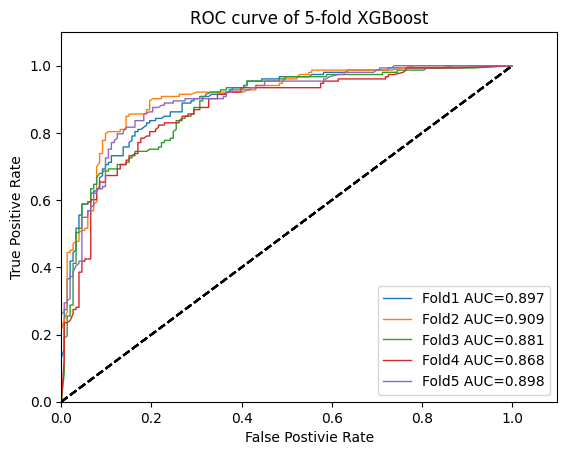

In [33]:
import xgboost as xgb
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

xgb_prob_list = []

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5):

    clf_xgb = xgb.XGBClassifier(n_estimators=5)
    clf_xgb.fit(feature_train_all[i],label_train_all[i])

    y_score = clf_xgb.predict(feature)                               
    y_score_pro = clf_xgb.predict_proba(feature) # (.., 2)
    y_one_hot = to_categorical(label)
    y_score_one_hot = to_categorical(y_score)

    xgb_prob_list.append(y_score_pro)

    acc_list.append(accuracy_score(label, y_score))
    precision_list.append(precision_score(label, y_score))
    recall_list.append(recall_score(label, y_score))
    f1_list.append(f1_score(label, y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold XGBoost')
plt.savefig('images/roc-5fold-xgb.png',dpi=300)
plt.show()

#### Model 6: lightGBM

In [62]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

parameters = {
    'max_depth': [2,3,4,5,6],
    'num_leaves': [5,10,15,20],
}

gbm = lgb.LGBMClassifier()
gsearch = GridSearchCV(gbm, param_grid=parameters, scoring='roc_auc', cv=3)
gsearch.fit(feature_train_all[0],label_train_all[0])
gsearch.best_params_

{'max_depth': 3, 'num_leaves': 5}

(mean) ACC:  0.8209150326797385 Precision:  0.8486329553066966 Recall:  0.9171171171171171 F1:  0.8814803088320193 AUC:  0.9093083856636337
(std) ACC:  0.022866478019001178 Precision:  0.019648011176902742 Recall:  0.010506219630351872 F1:  0.014385634043056504 AUC:  0.008521694016173184


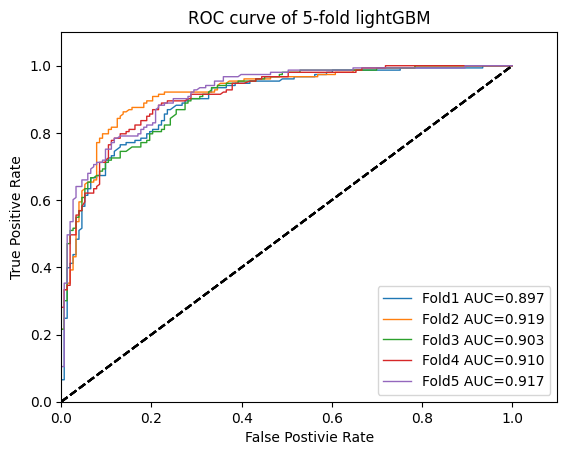

In [34]:
import lightgbm as lgb
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

gbm_prob_list = []

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5):

    clf_lgb = lgb.LGBMClassifier(max_depth=3, num_leaves=5)
    clf_lgb.fit(feature_train_all[i],label_train_all[i])

    y_score = clf_lgb.predict(feature)                               
    y_score_pro = clf_lgb.predict_proba(feature) # (.., 2)
    y_one_hot = to_categorical(label)
    y_score_one_hot = to_categorical(y_score)

    gbm_prob_list.append(y_score_pro)

    acc_list.append(accuracy_score(label, y_score))
    precision_list.append(precision_score(label, y_score))
    recall_list.append(recall_score(label, y_score))
    f1_list.append(f1_score(label, y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold lightGBM')
plt.savefig('images/roc-5fold-lightgbm.png',dpi=300)
plt.show()

#### Emden

[0.8300653594771242, 0.8300653594771242, 0.8431372549019608, 0.8431372549019608, 0.8235294117647058]
[0.9047619047619048, 0.8695652173913043, 0.8717948717948718, 0.848, 0.828125]
[0.8558558558558559, 0.9009009009009009, 0.918918918918919, 0.954954954954955, 0.954954954954955]
[0.8796296296296297, 0.8849557522123894, 0.8947368421052632, 0.8983050847457628, 0.8870292887029289]
[0.921440471613482, 0.9221666880259729, 0.9191336665385108, 0.9137938399760775, 0.9203297876884959]
(mean) ACC:  0.8339869281045752 Precision:  0.8644493987896162 Recall:  0.9171171171171171 F1:  0.8889313194791949 AUC:  0.9193728907685079
(std) ACC:  0.007843137254901962 Precision:  0.025672048532865532 Recall:  0.03710136987743062 F1:  0.006745603878953584 AUC:  0.00297250336782116


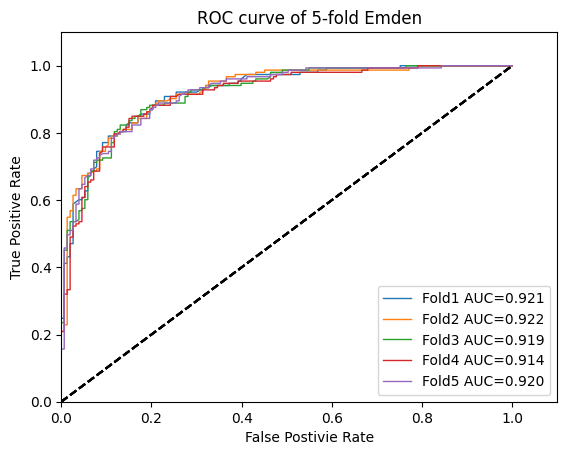

In [59]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

def softmax(vec):
    """Compute the softmax in a numerically stable way."""
    vec = vec - np.max(vec)  # softmax(x) = softmax(x+c)
    exp_x = np.exp(vec)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

emden_prob_list = []

for i in range(5):
    label = np.load('../model/pred_results/' + str(i+1) + 'fold_label.npy')
    pred = np.load('../model/pred_results/' + str(i+1) + 'fold_pred.npy')
    prob = np.load('../model/pred_results/' + str(i+1) + 'fold_pred_prob.npy')
    raw = np.load('../model/pred_results/' + str(i+1) + 'fold_pred_raw.npy')

    '''
    print(label)
    print(pred)
    #print(prob)
    print(raw)
    '''

    y_one_hot = to_categorical(label)
    y_score_pro_list = []
    for j in range(prob.shape[0]):
        y_score_pro_list.append([1-prob[j],prob[j]])
    y_score_pro = np.array(y_score_pro_list)

    emden_prob_list.append(y_score_pro)

    acc_list.append(accuracy_score(label, pred))
    precision_list.append(precision_score(label, pred))
    recall_list.append(recall_score(label, pred))
    f1_list.append(f1_score(label, pred))
    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print(acc_list)
print(precision_list)
print(recall_list)
print(f1_list)
print(auc_list)

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold Emden')
plt.savefig('images/roc-5fold-emden.png',dpi=300)
plt.show()

#### compare all

(153, 2)


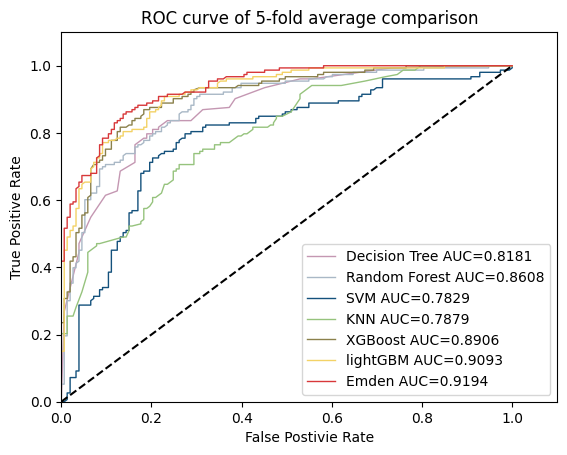

In [60]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

print(dt_prob_list[0].shape) # (153, 2)

def mean_prob(prob_list):
    sum_array = np.zeros((153,2))
    mean_array = np.zeros((153,2))
    for arr in prob_list:
        for i in range(153):
            sum_array[i][0] += arr[i][0]
            sum_array[i][1] += arr[i][1]
    for i in range(153):
        mean_array[i][0] = sum_array[i][0]/5
        mean_array[i][1] = sum_array[i][1]/5
    return mean_array

dt_prob = mean_prob(dt_prob_list)
rf_prob = mean_prob(rf_prob_list)
svm_prob = mean_prob(svm_prob_list)
knn_prob = mean_prob(knn_prob_list)
xgb_prob = mean_prob(xgb_prob_list)
gbm_prob = mean_prob(gbm_prob_list)
emden_prob = mean_prob(emden_prob_list)

y_one_hot = to_categorical(label)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_one_hot.ravel(),dt_prob.ravel())
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_one_hot.ravel(),rf_prob.ravel())
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_one_hot.ravel(),svm_prob.ravel())
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_one_hot.ravel(),knn_prob.ravel())
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_one_hot.ravel(),xgb_prob.ravel())
fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(y_one_hot.ravel(),gbm_prob.ravel())
fpr_emden, tpr_emden, thresholds_emden = roc_curve(y_one_hot.ravel(),emden_prob.ravel())

plt.plot(fpr_dt, tpr_dt, linewidth = 1,label='Decision Tree AUC=0.8181', color='#C497B2')
plt.plot(fpr_rf, tpr_rf, linewidth = 1,label='Random Forest AUC=0.8608', color='#A9B8C6')
plt.plot(fpr_svm, tpr_svm, linewidth = 1,label='SVM AUC=0.7829', color='#14517C')
plt.plot(fpr_knn, tpr_knn, linewidth = 1,label='KNN AUC=0.7879', color='#96C37D')
plt.plot(fpr_xgb, tpr_xgb, linewidth = 1,label='XGBoost AUC=0.8906', color='#8B814C')
plt.plot(fpr_gbm, tpr_gbm, linewidth = 1,label='lightGBM AUC=0.9093', color='#F3D266')
plt.plot(fpr_emden, tpr_emden, linewidth = 1,label='Emden AUC=0.9194', color='#D8383A')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold average comparison')
plt.savefig('images/5fold-comparison.png',dpi=300)
plt.show()